# Analyse time-dependent proteome

## 1. Load data into workbook

In [1]:
import cPickle as pkl
import re
import random
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh
import collections
from statsmodels.nonparametric.smoothers_lowess import lowess

Write part of the directory listing to a variable:

In [2]:
import platform
if platform.system()=="Windows":
    files = !ls ..\results\pol*
else:
    files = !ls ../results/pol*

Set up a dictionary that contains the simulation results.

In [3]:
filepaths = {}
for file in files:
    match = re.search(r'from (\w+)', file)
    filepaths[int(match.group(1).zfill(4))] = file

Function to replace _numpypy.multiarray by numpy.core.multiarray. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [4]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

Port from Pypy to Python:

In [5]:
for time in filepaths:
    print time,
    replace(filepaths[time], "_numpypy.multiarray", "numpy.core.multiarray")

0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


Create proteome dictionary:

In [4]:
results = {}
proteome = {}
for time in filepaths:
    print time,
    results[time] = pkl.load(open(filepaths[time]))
    proteome[time] = {key: results[time]['proteome'][key] for key in results[time]['proteome'] 
                     if results[time]['proteome'][key] > 1e-1}

0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


## 2. Test whether burn-in period has been long enough

Plot timecourses:

In [5]:
time = 300
protnames = results[time]['timecourses'].keys()
size = 5
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

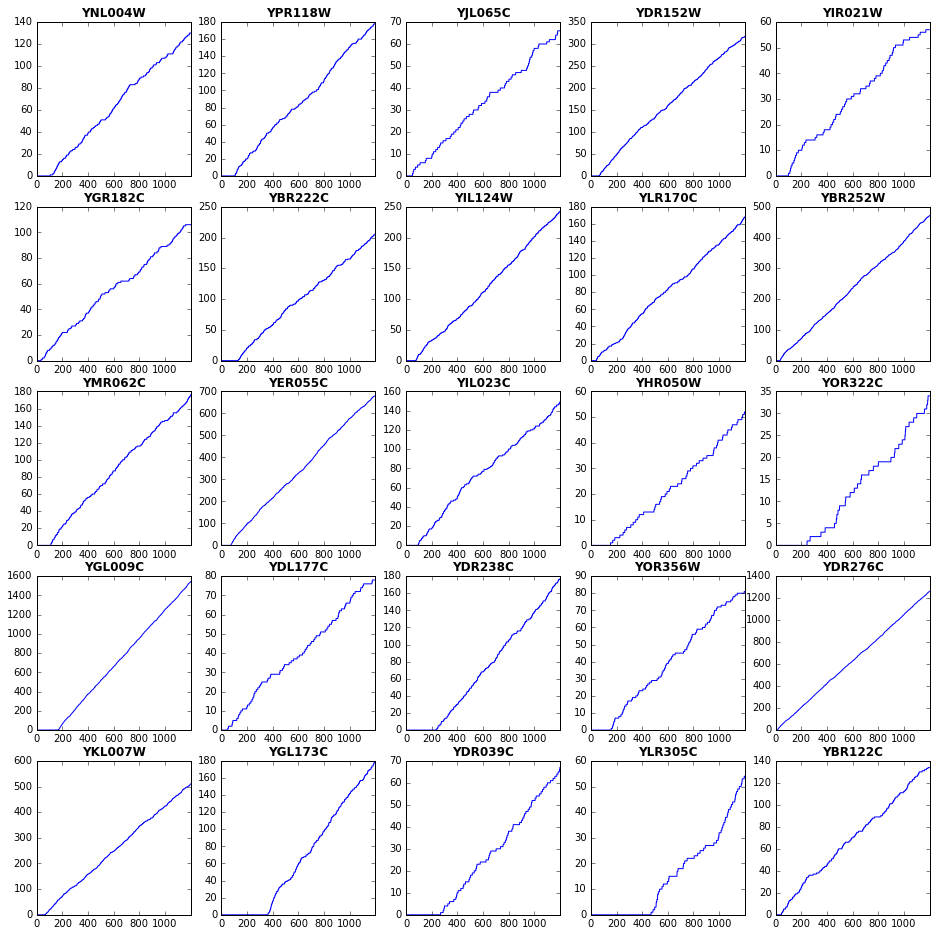

In [6]:
fig, ax = plt.subplots(size, size, figsize=(16, 16))

for i in range(size):
    for j in range(size):
        yseries = results[time]['timecourses'][protnames_plot[i][j]]
        xseries = np.arange(0., float(len(yseries)), 1.)
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 200.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=10)

Plot increases and check for saturation of "first derivative":

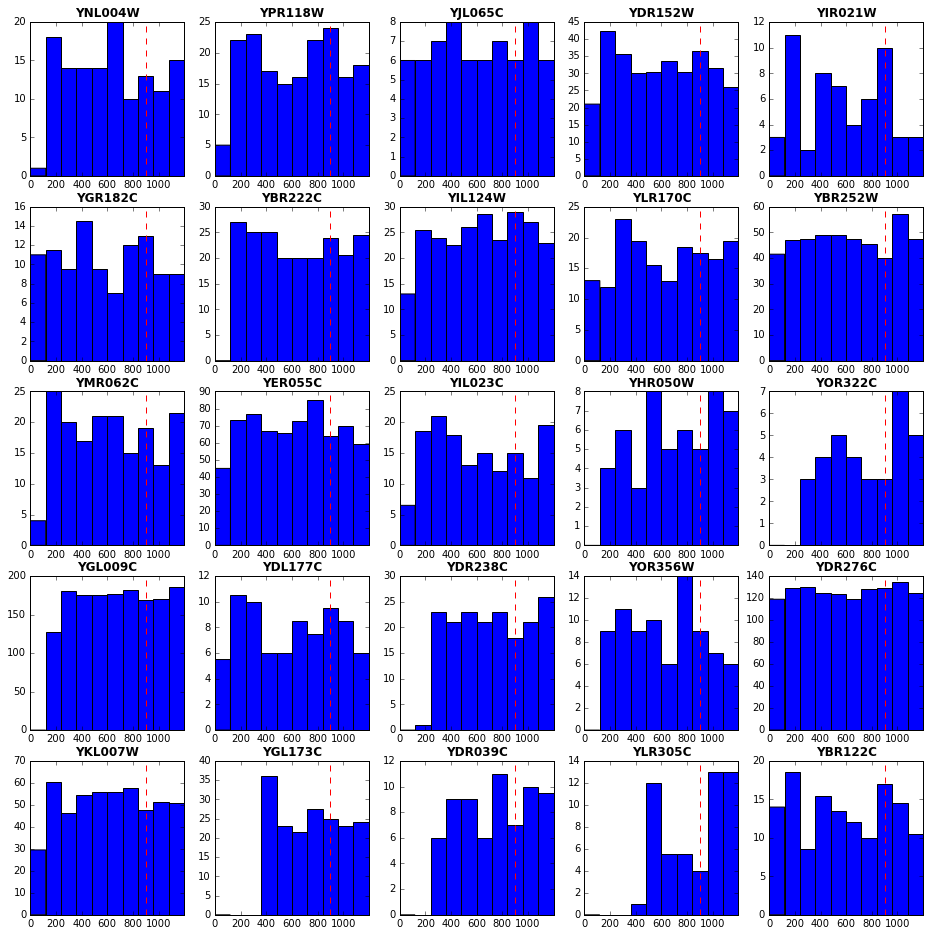

In [7]:
burnin = len(yseries) - 300  # 300 s simulation, rest is burn-in
fig, ax = plt.subplots(size, size, figsize=(16, 16))

for i in range(size):
    for j in range(size):
        yseries = results[time]['timecourses'][protnames_plot[i][j]]
        dy = np.gradient(yseries)
        xseries = np.arange(0., float(len(dy)), 1.)
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].hist(xseries, bins=10, weights=dy)
        ax[i, j].axvline(burnin, color='red', linestyle='--')
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 200.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=10)

## 3. Plot proteomes at different times

In [8]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, lws=True):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    #fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)
    
    # turn on lowess plott
    if lws:
        points = zip(xs, ys)
        sorted_points = sorted(points)
        new_xs = [point[0] for point in sorted_points]
        new_ys = [point[1] for point in sorted_points]
        ylowess = lowess(new_ys, new_xs)[:,1]
        plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    #plt.show()

Prevent output from scrolling:

In [9]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

3586


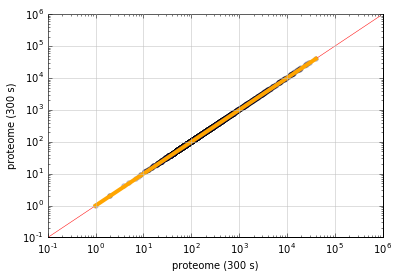

3161


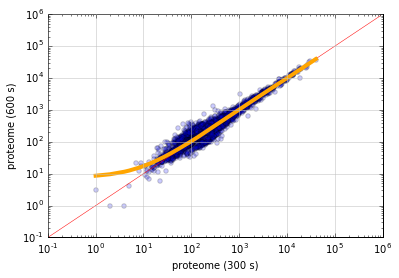

3161


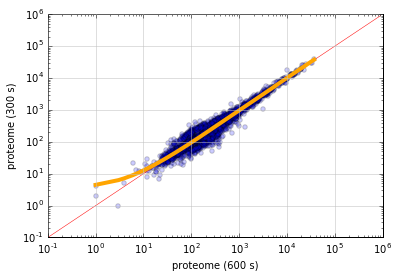

3560


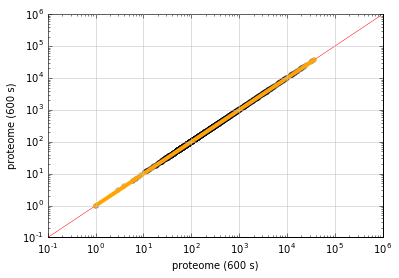

In [10]:
times = np.arange(0, 3600, 300)[:2]
#columns = 3
#rows = len(times/columns)
for tx in times:
    #fig, ax = plt.subplots(rows, columns, figsize=(16, 16))
    for ty in times:
        fig =  plt.figure()                
        plt.plot([1e-1, 1e6-100000], [1e-1, 1e6-100000], color='red', linestyle='-', linewidth=0.5)
        scatter_dicts(proteome[tx], proteome[ty], xaxislabel="proteome ({} s)".format(tx+300), 
                      yaxislabel="proteome ({} s)".format(ty+300), fontsize=None)
        plt.show()

## 4. Plot translational impact

First we check whether the relevant genes are in our data set.

Histones from http://wcmwiki.pbworks.com/w/page/103620021/20151208_Histones:

In [11]:
len(results[time]['timecourses'].keys())

3611

In [12]:
histones = ['YDR224C', 'YBL002W', 'YDR225W', 'YBL003C', 'YOL012C', 'YBR009C', 'YNL030W', 'YBR010W', 'YNL031C', 'YPL127C']

In [13]:
for histone in histones:
    print "Histone {} found in data set: {}".format(histone, histone in results[time]['timecourses'])

Histone YDR224C found in data set: True
Histone YBL002W found in data set: True
Histone YDR225W found in data set: True
Histone YBL003C found in data set: True
Histone YOL012C found in data set: True
Histone YBR009C found in data set: True
Histone YNL030W found in data set: True
Histone YBR010W found in data set: True
Histone YNL031C found in data set: True
Histone YPL127C found in data set: True


Transcription factors from https://bitbucket.org/wcm-team/gene_regulation/src/2cc7fcaefff9cd5ec89783253b281cebfbb88d32/model/input.py?at=master&fileviewer=file-view-default:

In [14]:
TFs = ["YNL027W", "YLR113W", "YMR174W", "YER062C", "YHR084W", "YDL056W", "YLR182W", "YER111C", "YLR118W", "YMR043W"]

In [15]:
for TF in TFs:
    print "TF {} found in data set: {}".format(TF, TF in results[time]['timecourses'])

TF YNL027W found in data set: True
TF YLR113W found in data set: True
TF YMR174W found in data set: False
TF YER062C found in data set: True
TF YHR084W found in data set: False
TF YDL056W found in data set: True
TF YLR182W found in data set: True
TF YER111C found in data set: True
TF YLR118W found in data set: False
TF YMR043W found in data set: True


Get mRNAs:

In [16]:
transcriptomes_dict = collections.OrderedDict(sorted(
        pkl.load((open('../parameters/transcriptome_time_dependent.p'))).items()))

In [17]:
transcriptomes_dict.keys()

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

In [18]:
absolute_transcript_count = {time: sum(transcriptomes_dict[time].values()) for time in sorted(transcriptomes_dict.keys())}

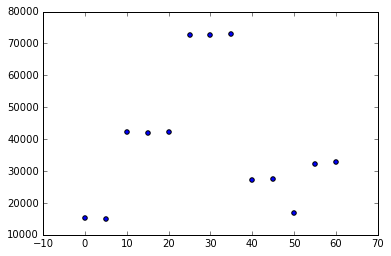

In [19]:
plt.scatter(absolute_transcript_count.keys(), absolute_transcript_count.values(), marker='o')

Generate fold-changes for transcriptome:

In [20]:
time = 30 * 60

In [21]:
print len(transcriptomes_dict[time/60])
print len(transcriptomes_dict[0])

6651
6651


In [22]:
def scatter_dicts_interactive(dict1,  dict2, xaxislabel=None, yaxislabel=None, fontsize=None):
    from bokeh.plotting import figure, show, ColumnDataSource
    from bokeh.models import HoverTool
    from bokeh.io import output_notebook
    
    plotkeys = list(dict1.viewkeys() & dict2.viewkeys()) # set intersection
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    plt.close()
    output_notebook()

    source = ColumnDataSource(data=dict(x=xs, y=ys, desc=plotkeys, ))

    hover = HoverTool(
            tooltips=[
                #("index", "$index"),
                #("(x,y)", "($x, $y)"),
                ("", "@desc"),
            ]
        )

    p = figure(plot_width=400, plot_height=400, tools=[hover,"wheel_zoom,box_zoom,reset"],
               x_axis_type="log", x_range=[1e-2, 1e3], 
               y_axis_type="log", y_range=[1e-2, 1e3], 
               title="",)

    p.scatter('x', 'y', size=5, source=source, fill_color=None, fill_alpha=0.6, line_color='red')

    show(p)

In [23]:
scatter_dicts_interactive(transcriptomes_dict[time/60], transcriptomes_dict[0])

Loading BokehJS ...

## 5. Analysis for WCM_GRN (abundant periodic genes found by Katja)

In [25]:
genes_shortlist = {'HHF1': 'YBR009C', 'HHF2': 'YNL030W', 'HHT1': 'YBR010W', 'HHT2': 'YNL031C', 'HTB1': 'YDR224C', 
                   'HTB2': 'YBL002W', 'PMA1': 'YGL008C', 'RNR1': 'YER070W', 'RNR2': 'YJL026W', 'RNR3': 'YIL066C', 
                   'RNR4': 'YGR180C'}

In [26]:
translation_rate_shortlist = {}

for (genecommon, gene) in genes_shortlist.items():
    translation_rate_shortlist[genecommon] = []
    for time in np.arange(0, 3600, 300):
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-301])/300.
        else:
            rate = 0.
        translation_rate_shortlist[genecommon].append(rate)

In [27]:
translation_ratedf = pd.DataFrame(translation_rate_shortlist, index=np.arange(0, 3600, 300))

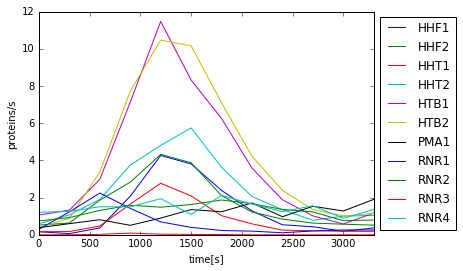

In [28]:
pl = translation_ratedf.plot()
pl.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
pl.set_xlabel("time[s]")
pl.set_ylabel("proteins/s")

In [29]:
translation_ratedf

,HHF1,HHF2,HHT1,HHT2,HTB1,HTB2,PMA1,RNR1,RNR2,RNR3,RNR4
0,0.163333,0.523333,0.166667,0.596667,1.063333,0.393333,0.383333,0.293333,0.743333,0.000000,1.210000
300,0.063333,0.633333,0.173333,1.070000,1.326667,0.886667,0.600000,1.233333,0.926667,0.000000,1.260000
600,0.370000,1.863333,0.470000,1.900000,2.980000,3.373333,0.810000,2.243333,1.310000,0.023333,1.506667
900,2.073333,2.830000,1.646667,3.746667,7.130000,7.710000,0.510000,1.420000,1.590000,0.090000,1.500000
1200,4.266667,4.323333,2.770000,4.806667,11.473333,10.466667,0.900000,0.693333,1.483333,0.033333,1.940000
1500,3.810000,3.873333,2.090000,5.746667,8.316667,10.160000,1.356667,0.400000,1.626667,0.020000,1.096667
1800,2.386667,2.106667,1.026667,3.630000,6.253333,7.093333,1.240000,0.230000,1.870000,0.013333,2.116667
2100,1.283333,1.226667,0.586667,2.056667,3.583333,4.223333,1.710000,0.196667,1.673333,0.000000,1.653333
2400,0.540000,0.843333,0.253333,1.350000,1.883333,2.390000,0.973333,0.110000,1.363333,0.000000,1.246667
2700,0.433333,0.630000,0.216667,0.776667,1.016667,1.356667,1.533333,0.206667,1.230000,0.000000,1.556667


In [30]:
transcriptome_df = pd.DataFrame(transcriptomes_dict).transpose()
del transcriptome_df[0]
transcriptome_df.index = np.arange(0, 3601, 300)
transcriptome_df

,Q0010,Q0017,Q0032,Q0045,Q0050,Q0055,Q0060,Q0065,Q0070,Q0075,...,YPR196W,YPR197C,YPR198W,YPR199C,YPR200C,YPR201W,YPR202W,YPR203W,YPR204C-A,YPR204W
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
600,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
900,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,0,0,0,0
1200,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
1500,0,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,0,0,0
1800,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,0,0,0,0,0,0
2100,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,0,0,0,0
2400,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2700,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [31]:
transcriptome_df_short = transcriptome_df[transcriptome_df.index<3600][genes_shortlist.values()]

In [32]:
transcriptome_df_short.columns = genes_shortlist.keys()
transcriptome_df_short

,HTB2,HTB1,HHF1,HHF2,PMA1,RNR2,RNR3,HHT2,RNR1,RNR4,HHT1
0,2,4,2,7,3,5,0,8,3,7,2
300,4,5,1,8,4,6,0,13,12,7,2
600,27,18,10,50,10,16,1,55,46,15,12
900,58,41,55,77,6,18,2,97,29,15,42
1200,77,65,106,107,11,16,1,119,14,19,70
1500,113,68,152,152,24,30,1,232,12,17,81
1800,75,48,91,81,22,29,1,141,6,29,40
2100,44,28,47,46,28,27,0,81,5,23,23
2400,12,8,8,15,8,10,0,20,1,8,4
2700,7,4,6,9,12,9,0,11,2,10,3


In [33]:
translation_rate_per_mrna = translation_ratedf/transcriptome_df_short

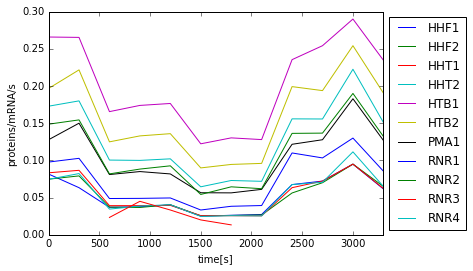

In [34]:
pl = translation_rate_per_mrna.plot()
pl.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
pl.set_xlabel("time[s]")
pl.set_ylabel("proteins/mRNA/s")

In [35]:
translation_rate_per_mrna

,HHF1,HHF2,HHT1,HHT2,HTB1,HTB2,PMA1,RNR1,RNR2,RNR3,RNR4
0,0.081667,0.074762,0.083333,0.074583,0.265833,0.196667,0.127778,0.097778,0.148667,NaN,0.172857
300,0.063333,0.079167,0.086667,0.082308,0.265333,0.221667,0.150000,0.102778,0.154444,NaN,0.180000
600,0.037000,0.037267,0.039167,0.034545,0.165556,0.124938,0.081000,0.048768,0.081875,0.023333,0.100444
900,0.037697,0.036753,0.039206,0.038625,0.173902,0.132931,0.085000,0.048966,0.088333,0.045000,0.100000
1200,0.040252,0.040405,0.039571,0.040392,0.176513,0.135931,0.081818,0.049524,0.092708,0.033333,0.102105
1500,0.025066,0.025482,0.025802,0.024770,0.122304,0.089912,0.056528,0.033333,0.054222,0.020000,0.064510
1800,0.026227,0.026008,0.025667,0.025745,0.130278,0.094578,0.056364,0.038333,0.064483,0.013333,0.072989
2100,0.027305,0.026667,0.025507,0.025391,0.127976,0.095985,0.061071,0.039333,0.061975,NaN,0.071884
2400,0.067500,0.056222,0.063333,0.067500,0.235417,0.199167,0.121667,0.110000,0.136333,NaN,0.155833
2700,0.072222,0.070000,0.072222,0.070606,0.254167,0.193810,0.127778,0.103333,0.136667,NaN,0.155667


In [36]:
translation_rate_per_mrna.to_csv('translation_rate_per_mrna.csv')

Comparison with initiation probabilities:translation_rate_per_mrna

In [37]:
init_rates = pkl.load(open("../parameters/init_rates_enhanced_median.p", "rb"))
init_rates_common = {gene: init_rates[genes_shortlist[gene]]*1e6 for gene in genes_shortlist}

11


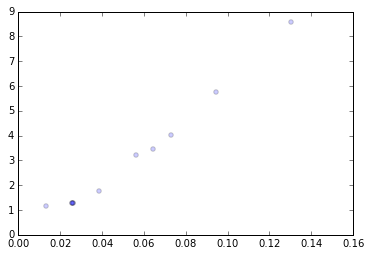

In [38]:
scatter_dicts(dict(translation_rate_per_mrna.ix[1800]), init_rates_common, xaxislabel='translation rate per transcript', 
              yaxislabel='initiation rate * 1E6', lws=False)

In [39]:
init_rates_common

{'HHF1': 1.291871859830537,
 'HHF2': 1.291871859830537,
 'HHT1': 1.291871859830537,
 'HHT2': 1.291871859830537,
 'HTB1': 8.580451211929118,
 'HTB2': 5.738927640019162,
 'PMA1': 3.2253823872000513,
 'RNR1': 1.7477148350729443,
 'RNR2': 3.4541884421416924,
 'RNR3': 1.1468920259159536,
 'RNR4': 4.039182074735152}